# Model training all folds d30_s30_vpos

In [1]:
import os
import pickle
import gc

import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader

from utils import get_cuda
from data_proc import read_data, remove_death, build_vocab
from dataset_func import build_dataset, BuildDataset, get_dataloader, read_pickled_ds
from transformer_model import TransformerCNNModel
from model_func import training_process, epoch_val, epoch_train

### Input

In [2]:
# Filepaths
num_folds = 5

main_dir = "../../../data/readmission/"
train_dirs = [os.path.join(main_dir, f"fold_{idx}/train/") for idx in range(num_folds)]
test_dirs = [os.path.join(main_dir, f"fold_{idx}/test/") for idx in range(num_folds)]
vocab_dirs = [os.path.join(main_dir, f"fold_{idx}/vocab/") for idx in range(num_folds)]

train_dl_fps = [os.path.join(train_dir, "train_datalist_d30_s30_vall_mf10.pkl") for train_dir in train_dirs]
test_dl_fps = [os.path.join(test_dir, "test_datalist_d30_s30_vall_mf10.pkl") for test_dir in test_dirs]
vocab_fps = [os.path.join(vocab_dir, f"vocab_d30_s30_vall_mf10") for vocab_dir in vocab_dirs]

#model_dir = "./models_d30_s30_vpos/"
# Options
x_lst = [str(x) for x in range(365, -1, -1)]
n_days = 60
seq_per_day = 30
y_target = "unplanned_readmission"
uid = "discharge_id"
batch_size=512

### Read in data and create data loader: single fold

In [3]:
emsize = 8 # embedding dimension
nhid = 32 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 1 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 1 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
n_class = 2

In [4]:
train_metric = {}
for fold, (train_fp, test_fp, vocab_fp) in enumerate(
    zip(train_dl_fps, test_dl_fps, vocab_fps)
):
    print("\n" + "*" * 30 + "Fold {}".format(fold) + "*" * 50)
    print(
        f"Processing \n \
        \t train: {train_fp} \n \
        \t test: {test_fp} \n \
        \t vocab: {vocab_fp} \n"
    )

    whole_ids, whole_data, whole_labels, whole_mask = read_pickled_ds(
        file_dir=train_fp, seq_length=n_days, event_length=seq_per_day
    )
        
    train_dataset = BuildDataset(
        data_list=[whole_ids, whole_data, whole_labels, whole_mask]
    )
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
    )

    whole_ids, whole_data, whole_labels, whole_mask = read_pickled_ds(
        file_dir=test_fp, seq_length=n_days, event_length=seq_per_day
    )
    test_dataset = BuildDataset(
        data_list=[whole_ids, whole_data, whole_labels, whole_mask]
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
    )
    
    vocab = torch.load(vocab_fp)
    ntokens = len(vocab.stoi)
    print(f"Nb tokens: {ntokens}")
    
    model = TransformerCNNModel(
        ntokens,
        emsize,
        nhead,
        nhid,
        nlayers,
        n_class,
        device="gpu",
        seq_length=30,
        num_events=30,
        dropout=dropout,
    )

    train_metric["fold_" + str(fold)] = training_process(
        model=model,
        epoch=15,
        dataloaders={"train": train_dataloader, "val": test_dataloader},
        save_model=None,
        test=False,
    )


******************************Fold 0**************************************************
Processing 
         	 train: ../../../data/readmission/fold_0/train/train_datalist_d30_s30_vall_mf10.pkl 
         	 test: ../../../data/readmission/fold_0/test/test_datalist_d30_s30_vall_mf10.pkl 
         	 vocab: ../../../data/readmission/fold_0/vocab/vocab_d30_s30_vall_mf10 

Nb tokens: 18884
parameters: embsize:8, nhead:1, nhid:32, nlayers:1, dropout:0.2
available device: cuda
number of GPUS available: 4
device: gpu
----------Epoch 1/15------------------------------
epoch_train_loss: 0.40704634534454187 epoch train AUC: 0.6394919515376724
epoch_val_loss: 0.40141144702165293 epoch val AUC: 0.661336894141375
----------Epoch 2/15------------------------------
epoch_train_loss: 0.40012672949588435 epoch train AUC: 0.6661656056928904
epoch_val_loss: 0.4013318356291167 epoch val AUC: 0.663836746399213
----------Epoch 3/15------------------------------
epoch_train_loss: 0.3979126809564238 epoch train

epoch_val_loss: 0.3995617832379793 epoch val AUC: 0.6676752272598311
----------Epoch 6/15------------------------------
epoch_train_loss: 0.3943801657664595 epoch train AUC: 0.6836694443380007
epoch_val_loss: 0.4005274958178109 epoch val AUC: 0.6667725701002153
----------Epoch 7/15------------------------------
epoch_train_loss: 0.3934154465605478 epoch train AUC: 0.6862688304581273
epoch_val_loss: 0.4007959219024462 epoch val AUC: 0.6666106008963582
----------Epoch 8/15------------------------------
epoch_train_loss: 0.3928271330896089 epoch train AUC: 0.6879349778917369
epoch_val_loss: 0.4016007000665649 epoch val AUC: 0.666025270920582
----------Epoch 9/15------------------------------
epoch_train_loss: 0.39203549292650663 epoch train AUC: 0.6899980947569797
epoch_val_loss: 0.40210380490406666 epoch val AUC: 0.6656237516205307
----------Epoch 10/15------------------------------
epoch_train_loss: 0.39157736170892093 epoch train AUC: 0.6912493460617127
epoch_val_loss: 0.40259946575936

epoch_val_loss: 0.4066056680367153 epoch val AUC: 0.6633083608899754
----------Epoch 13/15------------------------------
epoch_train_loss: 0.390699428451681 epoch train AUC: 0.6931902538893995
epoch_val_loss: 0.40484200410679005 epoch val AUC: 0.6618057617516937
----------Epoch 14/15------------------------------
epoch_train_loss: 0.39026826485912186 epoch train AUC: 0.6945528554811684
epoch_val_loss: 0.4072618169646021 epoch val AUC: 0.662518204077366
----------Epoch 15/15------------------------------
epoch_train_loss: 0.3900450803537716 epoch train AUC: 0.6949607899683651
epoch_val_loss: 0.40724878966710765 epoch val AUC: 0.661931633738266


In [8]:
overall_auc = []
print("individual fold results")
for idx in range(num_folds):
    print(f"fold_{idx}: {max(train_metric[f'fold_{idx}']['val_metric'])}")
    overall_auc.append(max(train_metric[f'fold_{idx}']['val_metric']))
          
print('Average AUC: {}'.format(np.round(np.mean(overall_auc), 3)))
print('Std AUC: {}'.format(np.round(np.std(overall_auc), 3)))

individual fold results
fold_0: 0.6641900503296384
fold_1: 0.6678958838182139
fold_2: 0.6684752631925022
fold_3: 0.6656183681881993
fold_4: 0.6659127608812653
Average AUC: 0.666
Std AUC: 0.002


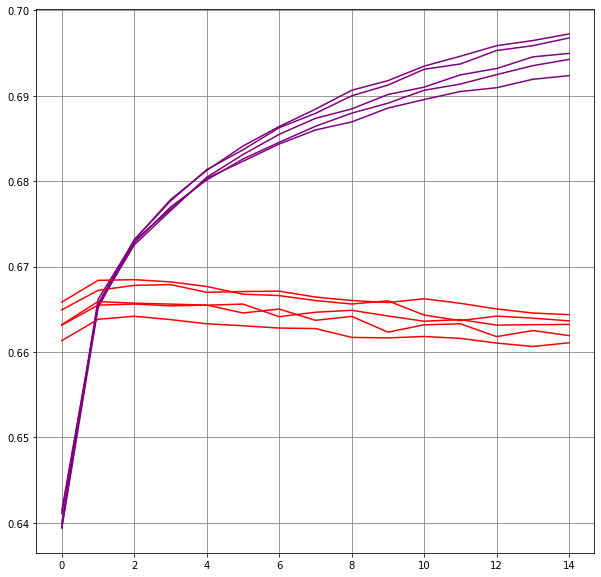

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for idx in range(num_folds):
    plt.plot(train_metric[f'fold_{idx}']['val_metric'], color='red')
    plt.plot(train_metric[f'fold_{idx}']['train_metric'], color='purple')
    
plt.grid(color='gray')
